## Model comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from constrNMPy import constrNMPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
plt.style.use('default')
plt.style.use('seaborn-v0_8-paper')
fulldata = pd.read_csv('../analysis/fulldata.csv')
per_gptdata = fulldata[fulldata.agent == 'gpt']
custom_colors = [sns.color_palette()[0],sns.color_palette()[3]]

c:\Users\Liangst.687\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Different Models

#### Models of learning

In [2]:
# Gaussian Process
# just with the scikit-learn library

In [3]:
# Option learning
# Bayesian Mean Tracker
def Tracker(mu:np.array,v:np.array,option:int,theta:float,y):
    """ Update the mean and variance of the posterior distribution of the Gaussian Process

    Args:
        mu (np.array): the mean estimation of the posteriors
        v (np.array): the variance estimation of the posteriors
        option (int): the choice of the 
        theta (float): hyperparameter of the model it seems the sensitivity
        y ([type]): the reward of the choice
    """
    
    # set the choice
    choices = np.zeros(mu.shape)
    choices[option] = 1

    # set the Git
    Git = v/(v+theta**2)

    # update 
    mu += choices*Git*(y-mu)
    v = v*(1-choices*Git)

    return mu,v

#### Sampling Strategy

In [4]:
# upper confidence bound
def UCB(mu:np.array,sigma:np.array,beta:float):
    """return the upper confidence bound of the Gaussian Process

    Args:
        mu (np.array): the mean estimation of the posteriors
        sigma (np.array): the variance estimation of the posteriors
        beta (float): direct the exploration

    Returns:
        _type_: the ultility of the choices
    """
    return mu+beta*sigma

In [5]:
# Entropy Regularization
def Entropy(mu:np.array,sigma:np.array,beta:float):
    """return the entropy of the Gaussian Process

    Args:
        mu (np.array): the mean estimation of the posteriors
        sigma (np.array): the variance estimation of the posteriors

    Returns:
        _type_: _description_
    """
    return mu+beta*0.5*np.log(2*np.pi*np.e*sigma**2)

In [6]:
# Pure Exploitation
def Exploit(mu:np.array):
    return mu

# Pure Exploration
def Explore(sigma:np.array):
    return sigma

In [7]:
# Expected Improvement
def EXI(x:np.array,mu:np.array,sigma:np.array):
    """return the expected improvement of the Gaussian Process

    Args:
        x (np.array): the choices
        mu (np.array): the mean estimation of the posteriors
        sigma (np.array): the variance estimation of the posteriors

    Returns:
        _type_: the ultility of the choices
    """
    x_star = x[np.argmax(mu[x])]
    z = (mu-mu[x_star])/sigma
    
    cdf = norm.cdf(z)
    pdf = norm.pdf(z)
    ultility = cdf*(mu-mu[x_star])+sigma*pdf
    ultility = np.where(ultility>1e-4,ultility,1e-4)
    return ultility

In [8]:
# Probability of Improvement
def POI(x:np.array,mu:np.array,sigma:np.array):
    """return the probability of improvement of the Gaussian Process

    Args:
        x (np.array): the choices
        mu (np.array): the mean estimation of the posteriors
        sigma (np.array): the variance estimation of the posteriors

    Returns:
        _type_: the ultility of the choices
    """
    x_star = x[np.argmax(mu[x])]
    z = (mu-mu[x_star])/sigma
    cdf = norm.cdf(z)
    cdf = np.where(cdf>1e-4,cdf,1e-4)
    return cdf

#### Simple Heuristic Strtegies

In [9]:
# win-stay lose-sample
def WSLS(x:np.array,y:np.array):
    """return the win-stay lose-sample of the Gaussian Process

    Args:
        x (np.array): the choices
        y (np.array): the reward of the choices

    Returns:
        _type_: the ultility of the choices
    """

    x_prev,y_prev = x[:-1],y[:-1]
    x_curr,y_curr = x[-1],y[-1]
    probalility = np.zeros(30)
    if y_curr >= np.max(y_prev):
        if x_curr == 0:
            probalility[x_curr:x_curr+2] = 1/2
        elif x_curr == 29:
            probalility[x_curr-1:x_curr+1] = 1/2
        else:
            probalility[x_curr-1:x_curr+2] = 1/3
    else:
        unchoiced_index = np.delete(np.arange(30),x_curr)
        probalility[unchoiced_index] = 1/len(unchoiced_index)
    
    return probalility

In [10]:
# Local Search
def IMD(x:np.array,y:np.array,beta:float,horizon,iter):
    """_summary_

    Args:
        x (np.array): the choice history

    Returns:
        _type_: _description_
    """
    x_range = np.arange(30)
    x_prev = x[-1]
    mu = np.ones(30)*0.5

    distance = abs(x_range-x_prev)
    distance = np.where(distance == 0,1,distance)

    for _ in range(len(x)):
        x_now = x[_]
        mu[x_now] = y[_]

    ultility = 1/distance + beta*np.exp(iter-horizon)*mu
    return ultility

#### Utility to action

In [11]:
def softmax(x, tau):
    max_x = np.max(x)
    shifted_x = x - max_x
    exp_x = np.exp(shifted_x / tau)
    sum_exp_x = np.sum(exp_x)
    prob = exp_x / sum_exp_x
    prob = np.maximum(prob, 1e-15)  # 避免 prob 过小
    return prob

### Fit pameters

In [12]:
# load data
per_gptdata = pd.read_csv('../analysis/per_gptdata.csv',index_col=0)
per_gptdata.x = per_gptdata.x -1 
per_gptdata.t.unique()

array([1. , 0.6, 0.8, 0. , 0.2, 0.4])

In [13]:
# class function learning
size = 30
def GP(paras:list,method:str,data:pd.DataFrame)->float:
    """_summary_

    Args:
        method (str): _sampling method_
        paras (list): _paras for modeling_
        data (pd.DataFrame): _sub data_

    Returns:
        float: _likelihood of the data_
    """
    options = np.arange(size)
    mu = np.array([0. for _ in range(size)])
    sigma = np.array([0.5 for _ in range(size)])
    length = paras[-1]
    kernel = RBF(length_scale = length)
    gp = GaussianProcessRegressor(kernel=kernel,optimizer=None,normalize_y=True)
    likelihood = 0

    # with 3 paras
    if (method == 'UCB') or (method == 'Entropy') or (method == 'Explore') or (method == 'Exploit'):
        # directed exploration, random exploration, and exploitation

        if (method == 'UCB') or (method == 'Entropy'):
            beta,tau,length = paras[0],paras[1],paras[2]
            for i in range(len(data)):
                params = (mu,sigma,beta)
                prob = softmax(eval(method)(*params),tau)
                choice = data.x.values[i]
                if i != 0:
                    likelihood += np.log(prob[choice])
                    
                # update the GP
                gp.fit(data.x.values[:i+1].reshape(-1, 1),data.z.values[:i+1].reshape(-1, 1))
                mu,sigma = gp.predict(options.reshape(-1,1),return_std=True)
                
        else:
            tau,length = paras[0],paras[1]
            for i in range(len(data)):
                if method == 'Exploit':
                    prob = softmax(Exploit(mu),tau)
                else:
                    prob = softmax(Explore(sigma),tau)
                    
                choice = data.x.values[i]
                if i != 0:
                    likelihood += np.log(prob[choice])

                # update the GP
                gp.fit(data.x.values[:i+1].reshape(-1, 1),data.z.values[:i+1].reshape(-1, 1))
                mu,sigma = gp.predict(options.reshape(-1,1),return_std=True)

    
    if (method == 'EXI') or (method == 'POI'):
        tau,length = paras[0],paras[1] # just the temperature
        for i in range(len(data)):
            x = data.x.values[:i+1]
            params = (x,mu,sigma)
            prob = softmax(eval(method)(*params),tau)
            choice = data.x.values[i]
            if i != 0:
                likelihood += np.log(prob[choice])
            
            # update the GP
            gp.fit(data.x.values[:i+1].reshape(-1, 1),data.z.values[:i+1].reshape(-1, 1))
            mu,sigma = gp.predict(options.reshape(-1,1),return_std=True)
    
    return -likelihood


In [14]:
# class option learning
def OL(paras:list,method:str,data:pd.DataFrame)->float:
    """return the likelihood of the option learning fitting

    Args:
        method (str): _sampling strategy_
        paras (list): _used for modeling_
        data (pd.DataFrame): _sub data_

    Returns:
        : _likelihood of the option learning fitting_
    """

    options = np.arange(size)
    mu = np.array([0.5 for _ in range(size)])
    sigma = np.array([5 for _ in range(size)])
    likelihood = 0
        
    if (method == 'UCB') or (method == 'Entropy') or (method == 'Explore') or (method == 'Exploit'):
        # with 3 paras
        # directed exploration, random exploration, and exploitation
        if (method == 'UCB') or (method == 'Entropy'):
            beta,tau,theta = paras[0],paras[1],paras[2]
            for i in range(len(data)):
                params = (mu,sigma,beta)
                prob = softmax(eval(method)(*params),tau)
                choice = data.x.values[i]
                if i != 0:
                    likelihood += np.log(prob[choice])
                # update the posterior with Bayesian Mean Tracker
                mu,sigma = Tracker(mu,sigma,choice,theta,data.z.values[i]/100)
                

        else:
            tau,theta= paras[0],paras[1]
            for i in range(len(data)):
                if method == 'Exploit':
                    prob = softmax(Exploit(mu),tau)
                else:
                    prob = softmax(Explore(sigma),tau)
                    
                choice = data.x.values[i]
                if i != 0:
                    likelihood += np.log(prob[choice])
                # update the posterior with Bayesian Mean Tracker
                mu,sigma = Tracker(mu,sigma,choice,theta,data.z.values[i]/100)
                
    if (method == 'EXI') or (method == 'POI'):
        # with 2 paras
        tau,theta = paras[0],paras[1]
        for i in range(len(data)):
            x = data.x.values[:i+1]
            params = (x,mu,sigma)
            prob = softmax(eval(method)(*params),tau)
            choice = data.x.values[i]
            if i != 0:
                likelihood += np.log(prob[choice])
            
            # update the posterior with Bayesian Mean Tracker
            mu,sigma = Tracker(mu,sigma,choice,theta,data.z.values[i]/100) 
            
    return -likelihood

In [15]:
# class heuristic learning
def heuristic(paras:list,method:str,data:pd.DataFrame)->float:
    """return the likelihood of the heuristic learning fitting

    Args:
        paras (list): _used for modeling_
        method (str): _sampling strategy_
        data (pd.DataFrame): _sub data_

    Returns:
        : _likelihood of the heuristic learning fitting_
    """
    options = np.arange(size)
    likelihood = 0
    if method == 'WSLS':
        tau = paras[0]
        for i in range(1,len(data)):
            params = (data.x.values[:i+1],data.z.values[:i+1]/100)
            prob = softmax(eval(method)(*params),tau)
            choice = data.x.values[i]
            if i != 0:
                likelihood += np.log(prob[choice])
    
    if method == 'IMD':
        beta,tau = paras[0],paras[1]
        for i in range(len(data)):
            params = (data.x.values[:i+1],data.z.values[:i+1]/100,beta,len(data)-1,i)
            prob = softmax(eval(method)(*params),tau)
            choice = data.x.values[i]
            if i != 0:
                likelihood += np.log(prob[choice])
    
    return -likelihood

In [16]:
# start to fit with learning and decision making model
path = 'fit_params/'
learning = ['OL','OL']
methods = ['UCB','Entropy','Explore','Exploit','EXI','POI']
ids = per_gptdata.id.unique()
for i in range(len(learning)):
    for j in range(len(methods)):
        method = methods[j]

        for k in range(len(ids)):
            data = per_gptdata[per_gptdata.id == ids[k]]
            paras = []
            N_random=10               #重复取值20次
            optimal=[]
            args = [method,data]
            for _ in range(N_random):
                if j < 2:
                    LB = [1e-16]*3;UB = [10-1e-16]*3
                    x0 = np.random.uniform(0, 3, 3)
                else:
                    LB = [1e-16]*2;UB = [10-1e-16]*2
                    x0 = np.random.uniform(0, 3, 2)

                if learning[i] == 'GP':
                    xopt = constrNMPy.constrNM(GP, x0, LB, UB, args=args)
                elif learning[i] == 'OL':
                    xopt = constrNMPy.constrNM(OL, x0, LB, UB, args=args)
                optimal.append(xopt['xopt'])
                print(f' {learning[i]} {method} sub{k}//{len(ids)} iter{_} finished')
            if learning[i] == 'GP':
                y = list(map(lambda x: GP(x, method,data), optimal)) 
            else:
                y = list(map(lambda x: OL(x, method,data), optimal))
            opt = optimal[y.index(min(y))]

            # 保存最优参数
            for t in range(len(data)):
                paras.append(opt)
            
            if j<4:
                if i == 0:
                    columns = ['beta','tau','length']
                else:
                    columns = ['beta','tau','theta']
            else:
                if i == 0:
                    columns = ['tau','length']
                else:
                    columns = ['tau','theta']

            file_name = f'{learning[i]}_{method}_{k}.csv'
            paras = pd.DataFrame(paras,columns=columns)
            paras.to_csv(path+file_name)

 OL UCB sub0//462 iter0 finished
 OL UCB sub0//462 iter1 finished
 OL UCB sub0//462 iter2 finished
 OL UCB sub0//462 iter3 finished
 OL UCB sub0//462 iter4 finished
 OL UCB sub0//462 iter5 finished
 OL UCB sub0//462 iter6 finished
 OL UCB sub0//462 iter7 finished
 OL UCB sub0//462 iter8 finished
 OL UCB sub0//462 iter9 finished
 OL UCB sub1//462 iter0 finished
 OL UCB sub1//462 iter1 finished
 OL UCB sub1//462 iter2 finished
 OL UCB sub1//462 iter3 finished
 OL UCB sub1//462 iter4 finished
 OL UCB sub1//462 iter5 finished
 OL UCB sub1//462 iter6 finished


KeyboardInterrupt: 

In [ ]:
# start to fit with learning and decision making model
path = 'fit_params/'
learning = ['heuristic']
methods = ['IMD','WSLS']

ids = per_gptdata.id.unique()
for i in range(len(learning)):
    for j in range(len(methods)):
        method = methods[j]

        for k in range(len(ids)):
            data = per_gptdata[per_gptdata.id == ids[k]]
            paras = []
            N_random=10               #重复取值10次
            optimal=[]
            args = [method,data]
            for _ in range(N_random):  
                if j == 0:
                    LB = [1e-16]*2;UB = [10-1e-16]*2
                    x0 = np.random.uniform(0, 3, 2)
                else:   
                    LB = [1e-16];UB = [10-1e-16]
                    x0 = np.random.uniform(0, 3, 1)
                xopt = constrNMPy.constrNM(heuristic, x0, LB, UB, args=args)
                optimal.append(xopt['xopt'])
                print(f' {learning[i]} {method} sub{k}/{len(ids)} iter{_} finished')
            y = list(map(lambda x: heuristic(x,method,data), optimal))
            opt = optimal[y.index(min(y))]
            # 保存最优参数
            for t in range(len(data)):
                paras.append(opt)
            
            if j == 1:
                columns = ['tau']
            else:
                columns = ['beta','tau']
            file_name = f'heuristics_{method}_{k}.csv'
            paras = pd.DataFrame(paras,columns=columns)
            paras.to_csv(path+file_name)

 heuristic IMD sub0/80 iter0 finished
 heuristic IMD sub0/80 iter1 finished
 heuristic IMD sub0/80 iter2 finished
 heuristic IMD sub0/80 iter3 finished
 heuristic IMD sub0/80 iter4 finished
 heuristic IMD sub0/80 iter5 finished
 heuristic IMD sub0/80 iter6 finished
 heuristic IMD sub0/80 iter7 finished
 heuristic IMD sub0/80 iter8 finished
 heuristic IMD sub0/80 iter9 finished
 heuristic IMD sub1/80 iter0 finished
 heuristic IMD sub1/80 iter1 finished
 heuristic IMD sub1/80 iter2 finished
 heuristic IMD sub1/80 iter3 finished
 heuristic IMD sub1/80 iter4 finished
 heuristic IMD sub1/80 iter5 finished
 heuristic IMD sub1/80 iter6 finished
 heuristic IMD sub1/80 iter7 finished
 heuristic IMD sub1/80 iter8 finished
 heuristic IMD sub1/80 iter9 finished
 heuristic IMD sub2/80 iter0 finished
 heuristic IMD sub2/80 iter1 finished
 heuristic IMD sub2/80 iter2 finished
 heuristic IMD sub2/80 iter3 finished
 heuristic IMD sub2/80 iter4 finished
 heuristic IMD sub2/80 iter5 finished
 heuristic I

## Model comparison
With AIC

In [17]:
# AIC computation
def AIC(likelihood:float,paras_num:int):
    return 2*paras_num-2*likelihood

def BIC(likelihood,paras_num,n):
    return np.log(n)*paras_num-2*likelihood

### Compute the likelihood


In [18]:
# save data for the AIC and BIC
# for learning and sampling model
l_evaluation = pd.DataFrame(columns=['AIC','BIC','Learning','Sampling','id','horizons','environment'])

# for heuristic model
h_evaluation = pd.DataFrame(columns=['AIC','BIC','Model','id','horizons','environment'])

In [19]:
per_gptdata = pd.read_csv('../analysis/per_gptdata.csv')
per_gptdata.x = per_gptdata.x-1
per_gptdata.id.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [20]:
# Different Models
learning_methods = ['GP','OL']
sampling_methods = ['UCB','Entropy','Explore','Exploit','EXI','POI']
heuristic_methods = ['IMD','WSLS']
ids = per_gptdata.id.unique()
para_path = 'new_fit/'

# compute the likelihood
for i in range(len(learning_methods)):
    learning = learning_methods[i]
    for j in range(len(sampling_methods)):
        sampling = sampling_methods[j]
        for k in range(len(ids)):
            # start to read the likelihood
            data = per_gptdata[per_gptdata.id == ids[k]]
            t = data.t.values[0]
            para_file = para_path+f'{learning}_{sampling}_{k}_{t}.csv'
            paras = pd.read_csv(para_file,index_col=0)
            paras = paras.iloc[0,:].values

            if learning == 'GP':
                likelihood = GP(paras,sampling,data)

            else:
                likelihood = OL(paras,sampling,data)
            aic = AIC(-likelihood,len(paras)) 
            bic = BIC(-likelihood,len(paras),len(data)-1)
            
            horizons = data.horizons.values[0]
            environment = data.environment.values[0]    
            l_perdata = pd.DataFrame({'AIC':aic,'BIC':bic,'Learning':learning,'Sampling':sampling,'id':ids[k],'horizons':horizons,'environment':environment,'t':t},index=[0])
            l_evaluation = pd.concat([l_evaluation,l_perdata],ignore_index=True)
l_evaluation.to_csv('l_evaluation_new.csv')

C:\Users\Liangst.687\AppData\Local\Temp\ipykernel_3024\459121614.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  l_evaluation = pd.concat([l_evaluation,l_perdata],ignore_index=True)
C:\Users\Liangst.687\AppData\Local\Temp\ipykernel_3024\2963214706.py:14: RuntimeWarning: divide by zero encountered in divide
  z = (mu-mu[x_star])/sigma
C:\Users\Liangst.687\AppData\Local\Temp\ipykernel_3024\2963214706.py:14: RuntimeWarning: invalid value encountered in divide
  z = (mu-mu[x_star])/sigma
C:\Users\Liangst.687\AppData\Local\Temp\ipykernel_3024\2963214706.py:14: RuntimeWarning: invalid value encountered in divide
  z = (mu-mu[x_star])/sigma
C:\Users\Liangst.687\AppData\Local\Temp\ipykernel_3024\2963214706.py:14: RuntimeWarning: divide by zero

In [ ]:
l_evaluation.groupby(['Learning','Sampling'])[['AIC','BIC']].mean()

AIC        BIC
Learning Sampling                      
GP       EXI       47.000447  46.900468
         Entropy   41.725510  41.575541
         Exploit   46.903649  46.753680
         Explore   59.179208  59.029238
         POI       46.574429  46.474449
         UCB       42.064869  41.914899
OL       EXI       53.964905  53.864926
         Entropy   51.927582  51.777613
         Exploit   52.901844  52.751875
         Explore   56.026303  55.876334
         POI       50.940801  50.840821
         UCB       51.957231  51.807262

In [ ]:
per_gptdata[per_gptdata.id == 3]


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,trials,x,z,z_scaled,kernel,globalmax,t,id,environment,horizons,agent,Edistance
18,18,18,0,0,19,43.322669,27,13,62,0.0,3,rough,5,per_gpt,-1
19,19,19,1,1,18,58.511946,37,13,62,0.0,3,rough,5,per_gpt,1
20,20,20,2,2,20,23.271371,15,13,62,0.0,3,rough,5,per_gpt,2
21,21,21,3,3,18,58.511946,36,13,62,0.0,3,rough,5,per_gpt,2
22,22,22,4,4,17,98.987797,63,13,62,0.0,3,rough,5,per_gpt,1
23,23,23,5,5,16,100.000000,61,13,62,0.0,3,rough,5,per_gpt,1


In [21]:
# strategy for the heuristic model
heuristic_methods = ['WSLS','IMD']
ids = per_gptdata.id.unique()
para_path = 'new_fit/'
ids = per_gptdata.id.unique()

# compute the likelihood
for i in range(len(heuristic_methods)):
    heuristic_method = heuristic_methods[i]
    for j in range(len(ids)):
        # start to read the likelihood
        data = per_gptdata[per_gptdata.id == ids[j]]
        q = data.t.unique()[0]
        para_file = para_path+f'heuristics_{heuristic_method}_{j}_{q}.csv'
        paras = pd.read_csv(para_file,index_col=0)
        paras = paras.iloc[0,:].values

        likelihood = heuristic(paras,heuristic_method,data)
        aic = AIC(-likelihood,len(paras))
        bic = BIC( -likelihood,len(paras),len(data)-1)

        horizons = data.horizons.values[0]
        environment = data.environment.values[0]
        h_perdata = pd.DataFrame({'AIC':aic,'BIC':bic,'Model':heuristic_method,'id':ids[k],'horizons':horizons,'environment':environment,'t':q},index=[0])
        h_evaluation = pd.concat([h_evaluation,h_perdata],ignore_index=True)
h_evaluation.to_csv('h_evaluation_new.csv')

C:\Users\Liangst.687\AppData\Local\Temp\ipykernel_3024\1695243068.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  h_evaluation = pd.concat([h_evaluation,h_perdata],ignore_index=True)


In [22]:
h_evaluation.groupby(['Model','t'])[['AIC','BIC']].mean()

AIC        BIC
Model t                        
IMD   0.0  19.125910  19.037933
      0.2  19.234714  19.146737
      0.4  19.371746  19.283769
      0.6  18.886673  18.798696
      0.8  19.140179  19.005992
      1.0  18.915439  18.796426
WSLS  0.0  42.408862  42.364873
      0.2  42.595704  42.551715
      0.4  43.544095  43.500106
      0.6  43.173767  43.129778
      0.8  42.607139  42.540046
      1.0  41.372790  41.313284

### model revocery

In [ ]:
l_evaluation

,AIC,BIC,Learning,Sampling,id,horizons,environment,t
0,12.734592,11.562905,GP,UCB,0,5,smooth,1.0
1,21.551324,20.379637,GP,UCB,1,5,rough,0.6
2,31.051369,29.879683,GP,UCB,2,5,rough,0.8
3,30.627254,29.455568,GP,UCB,3,5,rough,0.0
4,32.836799,31.665113,GP,UCB,4,5,rough,0.2
...,...,...,...,...,...,...,...,...
5539,37.263405,36.482281,OL,POI,457,5,smooth,0.2
5540,35.691989,34.910865,OL,POI,458,5,smooth,0.4
5541,37.142771,36.361647,OL,POI,459,5,smooth,0.6
5542,37.906602,37.125478,OL,POI,460,5,smooth,0.8


In [ ]:
h_evaluation

,AIC,BIC,Model,id,horizons,environment,t
0,18.975847,18.585285,WSLS,3,5,rough,0.0
1,18.975847,18.585285,WSLS,3,5,rough,0.0
2,18.975847,18.585285,WSLS,3,5,rough,0.0
3,18.975847,18.585285,WSLS,3,5,rough,0.0
4,18.975847,18.585285,WSLS,3,5,rough,0.0
...,...,...,...,...,...,...,...
3691,14.927653,14.146529,IMD,3,5,smooth,0.2
3692,14.832515,14.051390,IMD,3,5,smooth,0.4
3693,10.327869,9.546745,IMD,3,5,smooth,0.6
3694,14.986123,14.204999,IMD,3,5,smooth,0.8


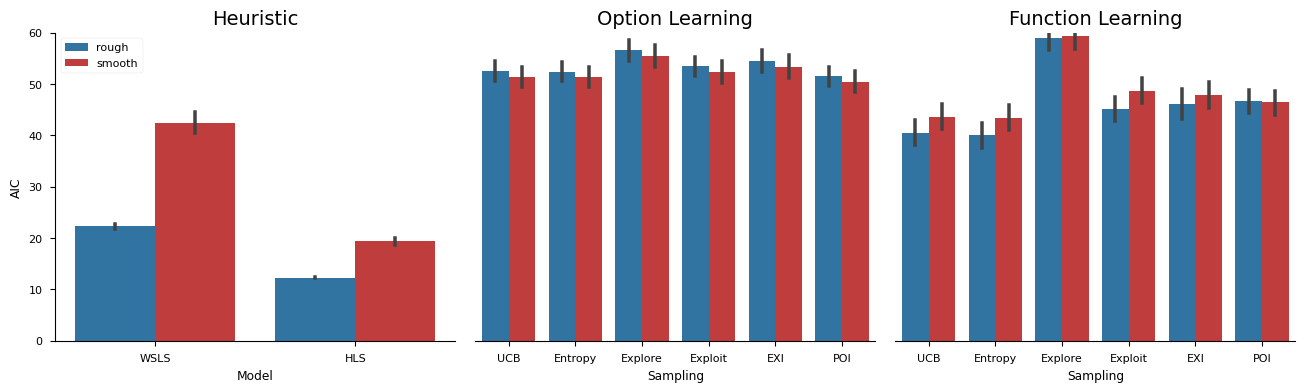

In [ ]:
fig,axes = plt.subplots(1,3,figsize = (16,4))
h_evaluation['Model'] = h_evaluation['Model'].replace('IMD','HLS')
p1 = sns.barplot(x='Model',y='AIC',hue='environment',palette=custom_colors,data=h_evaluation,ax=axes[0])
p2 = sns.barplot(x='Sampling',y='AIC',hue='environment',palette=custom_colors,data=l_evaluation[l_evaluation.Learning == 'OL'],ax=axes[1])
p3 = sns.barplot(x='Sampling',y='AIC',hue='environment',palette=custom_colors,data=l_evaluation[l_evaluation.Learning == 'GP'],ax=axes[2])
p1.legend(loc='upper left')
titles = ['Heuristic','Option Learning','Function Learning']

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylim([0,60])

for i in range(len(axes)):
    axes[i].set_title(titles[i],fontsize=14)
    if i > 0:
        axes[i].set_ylabel(None)
        axes[i].set_yticks([])
        axes[i].legend_.remove()
        axes[i].spines['left'].set_color('none')

plt.subplots_adjust(wspace=0.05)

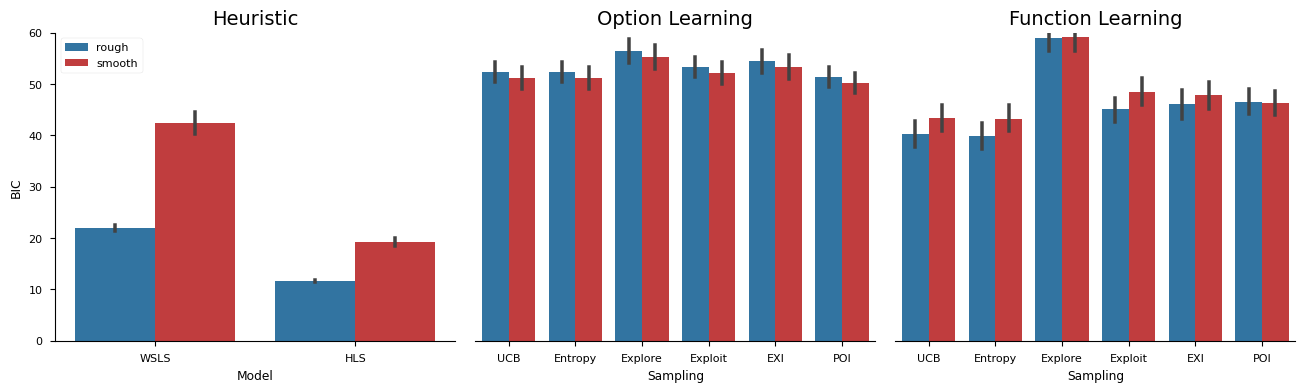

In [ ]:
fig,axes = plt.subplots(1,3,figsize = (16,4))
h_evaluation['Model'] = h_evaluation['Model'].replace('IMD','HLS')
p1 = sns.barplot(x='Model',y='BIC',hue='environment',palette=custom_colors,data=h_evaluation,ax=axes[0])
p2 = sns.barplot(x='Sampling',y='BIC',hue='environment',palette=custom_colors,data=l_evaluation[l_evaluation.Learning == 'OL'],ax=axes[1])
p3 = sns.barplot(x='Sampling',y='BIC',hue='environment',palette=custom_colors,data=l_evaluation[l_evaluation.Learning == 'GP'],ax=axes[2])
p1.legend(loc='upper left')
titles = ['Heuristic','Option Learning','Function Learning']

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylim([0,60])

for i in range(len(axes)):
    axes[i].set_title(titles[i],fontsize=14)
    if i > 0:
        axes[i].set_ylabel(None)
        axes[i].set_yticks([])
        axes[i].legend_.remove()
        axes[i].spines['left'].set_color('none')

plt.subplots_adjust(wspace=0.05)

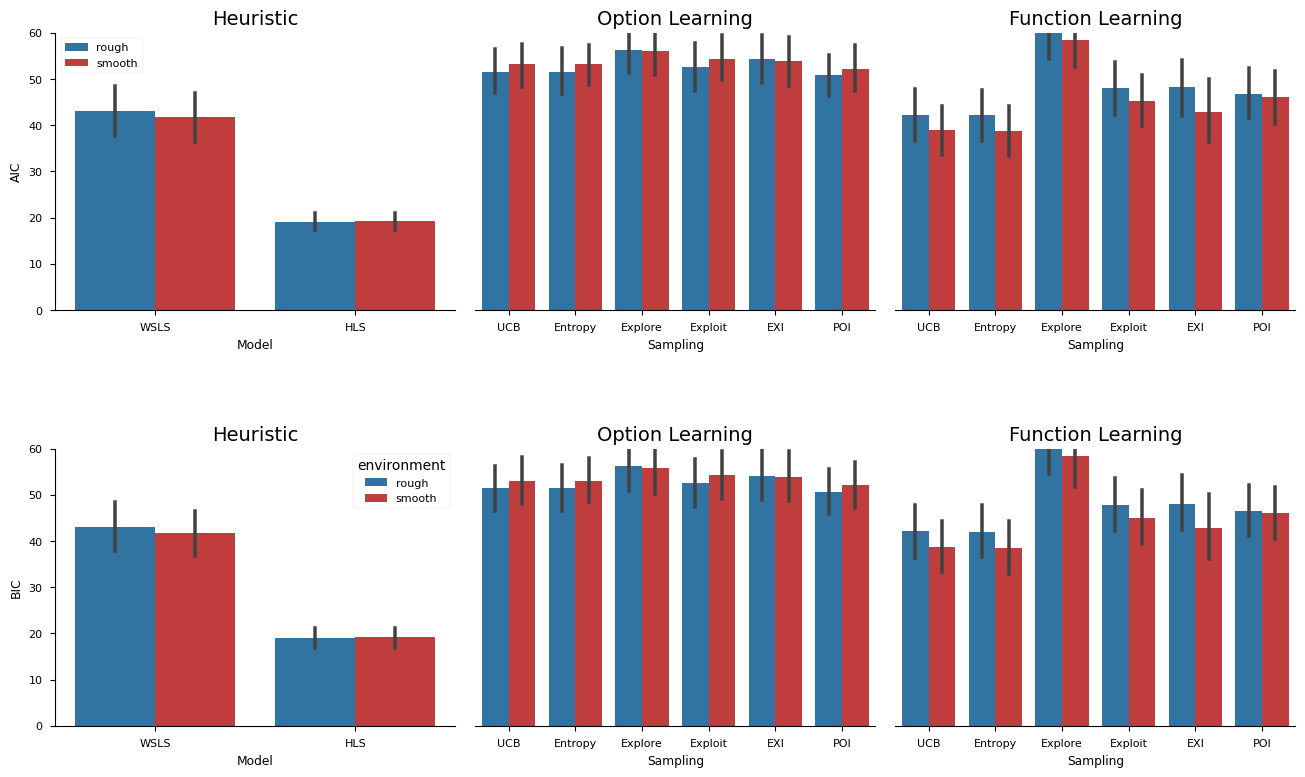

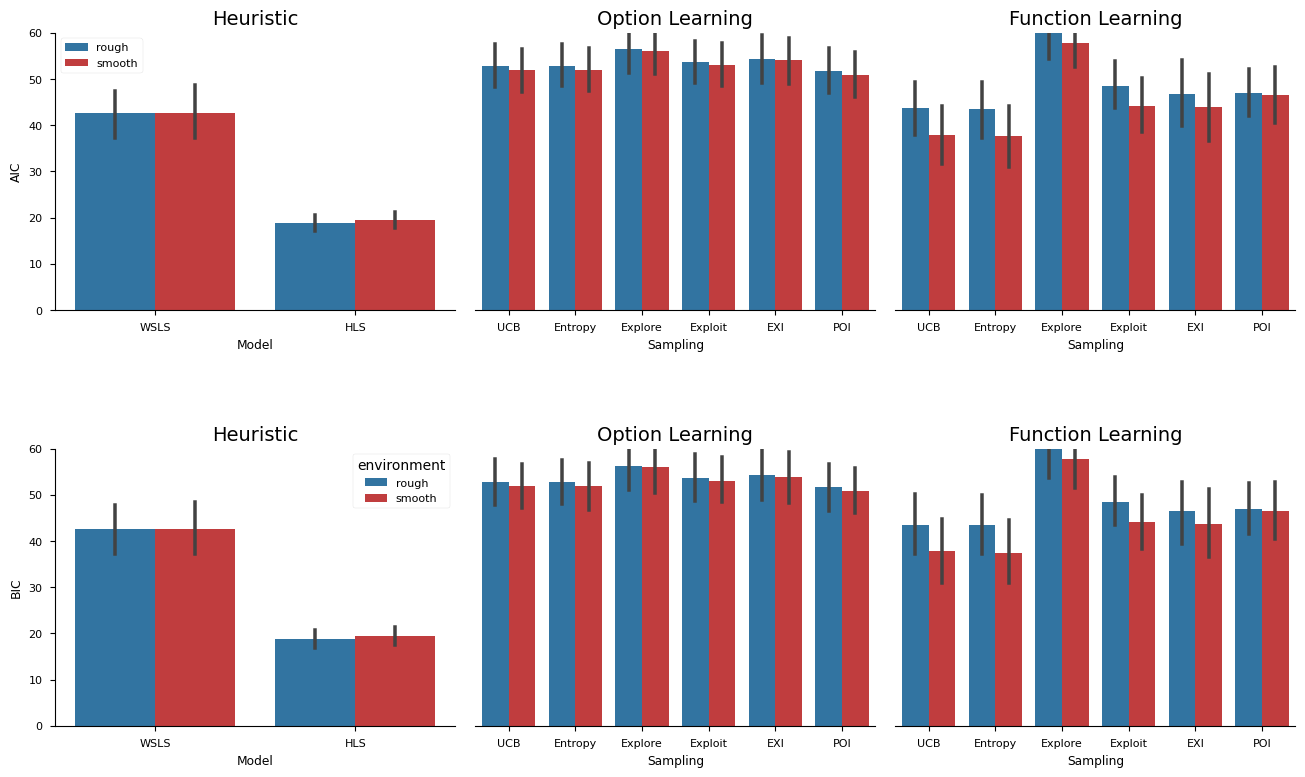

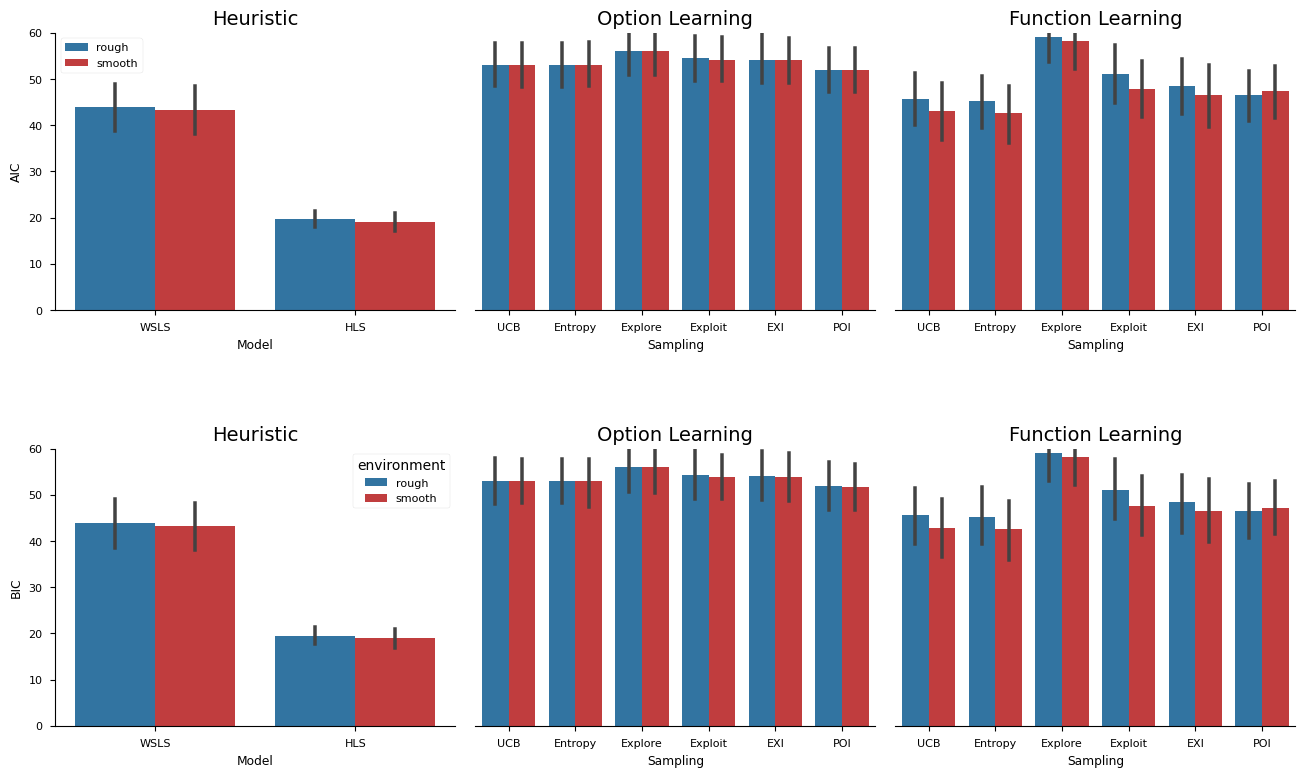

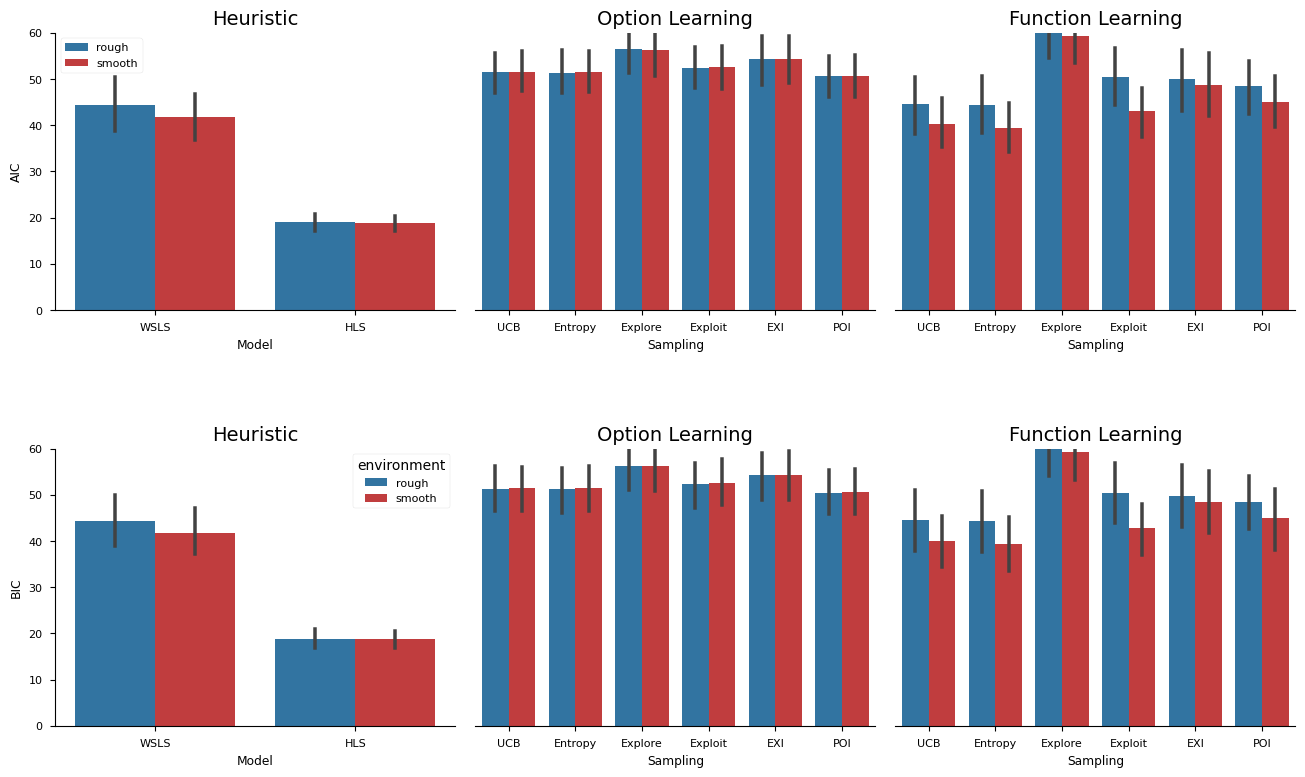

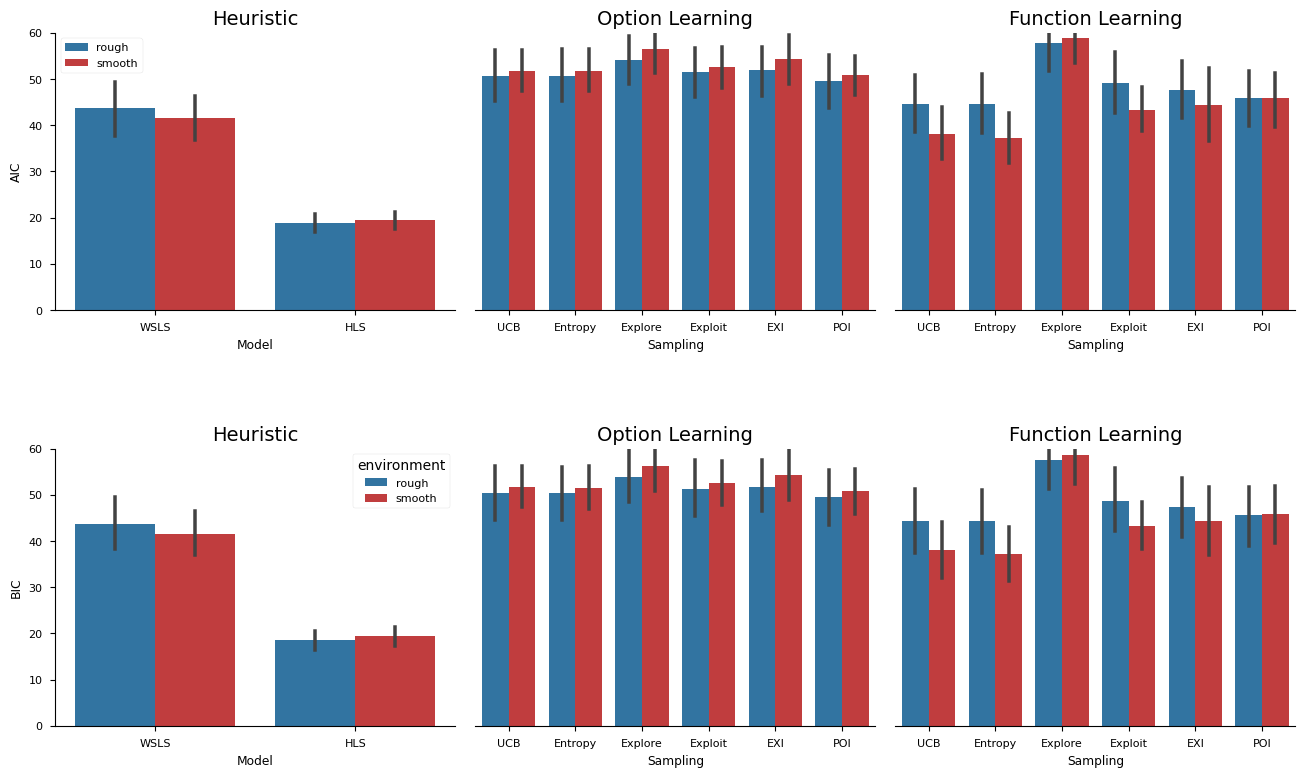

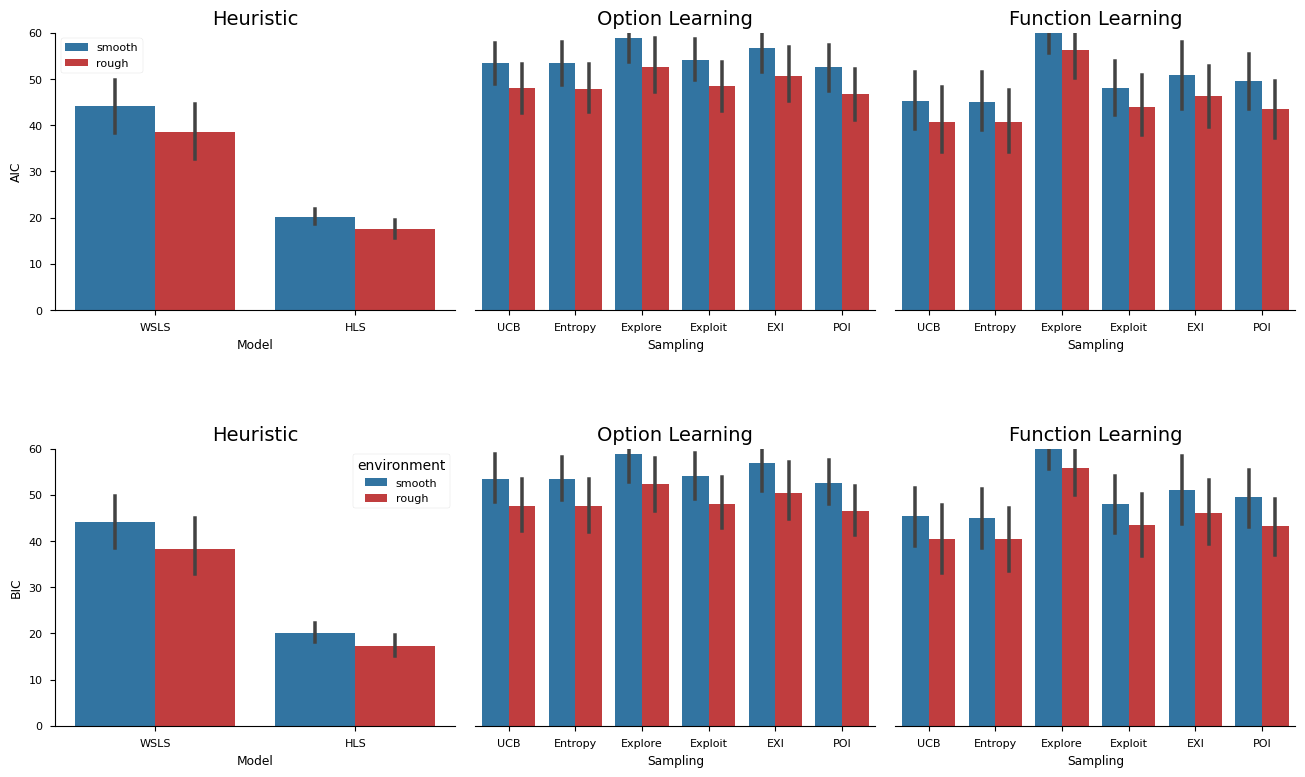

In [27]:
ts = [0.0,0.2,0.4,0.6,0.8,1.0]
for _ in range(len(ts)):
    t = ts[_]
    fig,axes = plt.subplots(2,3,figsize = (16,9))
    h_evaluation['Model'] = h_evaluation['Model'].replace('IMD','HLS')
    p1 = sns.barplot(x='Model',y='AIC',hue='environment',palette=custom_colors,data=h_evaluation[h_evaluation.t == t],ax=axes[0][0])
    p2 = sns.barplot(x='Sampling',y='AIC',hue='environment',palette=custom_colors,data=l_evaluation[(l_evaluation.Learning == 'OL') & (l_evaluation.t == t)],ax=axes[0][1])
    p3 = sns.barplot(x='Sampling',y='AIC',hue='environment',palette=custom_colors,data=l_evaluation[(l_evaluation.Learning == 'GP') & (l_evaluation.t == t)],ax=axes[0][2])
    p1.legend(loc='upper left')
    titles = ['Heuristic','Option Learning','Function Learning']
    p4 = sns.barplot(x='Model',y='BIC',hue='environment',palette=custom_colors,data=h_evaluation[h_evaluation.t == t],ax=axes[1][0])
    p5 = sns.barplot(x='Sampling',y='BIC',hue='environment',palette=custom_colors,data=l_evaluation[(l_evaluation.Learning == 'OL') & (l_evaluation.t == t)],ax=axes[1][1])
    p6 = sns.barplot(x='Sampling',y='BIC',hue='environment',palette=custom_colors,data=l_evaluation[(l_evaluation.Learning == 'GP') & (l_evaluation.t == t)],ax=axes[1][2])

    for i in range(2):
        for j in range(3):
            axes[i][j].set_title(titles[j],fontsize=14)
            axes[i][j].spines['right'].set_color('none')
            axes[i][j].spines['top'].set_color('none')
            axes[i][j].set_ylim([0,60])
            if j>0:
                axes[i][j].set_ylabel(None)
                axes[i][j].set_yticks([])
                axes[i][j].legend_.remove()
                axes[i][j].spines['left'].set_color('none')

    plt.subplots_adjust(wspace=0.05,hspace=0.5)
    plt.show()